In [1]:
import os 
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio 
import rioxarray as rio
from glob import glob
from rasterio.enums import Resampling
import xarray as xr
from scipy.stats import variation 
import rasterio.mask
from rasterstats import zonal_stats, gen_zonal_stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# File paths
data_in = os.path.join('../../course-materials/GPHY-491-591/data/tutorial011/')
data_out = os.path.join('./data/')

In [3]:
# Functions
def raster_clip(rst_fn, polys, fn_out):    
    """
    Clips a raster file to the extent of the provided polygons and saves the result to a new file.

    Args:
        rst_fn (str): The file path and name of the input raster (.tif) file that you want to clip.
        polys (list of dict or geopandas.GeoDataFrame): The polygons used to define the clipping region. These should be in the same coordinate reference system (CRS) as the raster.
        fn_out (str): The file path and name where the clipped raster (.tif) file will be saved.

    Process:
        1. Opens the input raster file.
        2. Clips the raster data based on the provided polygon geometry.
        3. Updates the raster's metadata to reflect the new dimensions and transformation.
        4. Saves the clipped raster data to the specified output file.

    Example:
        raster_clip('input.tif', [polygon1, polygon2], 'clipped_output.tif')

    Notes:
        - The polygons should be in GeoJSON format, or compatible geometry formats supported by `rasterio.mask`.
        - The clipping process will crop the raster to the bounding box of the polygons and mask out the areas outside the polygons.
        - The input and output files should be in GeoTIFF (.tif) format.
    """
    
    # clip raster
    with rasterio.open(rst_fn) as src:
        out_image, out_transform = rasterio.mask.mask(src, polys, crop=True)
        out_meta = src.meta
        
    # Update meta data
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(out_image)

In [4]:
esri_path = os.path.join(data_in + 'ESRI_WPE_2016_Pop/WPE_1KM_2016_Pop.tif')

In [5]:
rasterio.open(esri_path).meta

{'driver': 'GTiff',
 'dtype': 'int32',
 'nodata': -2147483647.0,
 'width': 40074,
 'height': 14285,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.008983196, 0.0, -179.99191516916386,
        0.0, -0.008983196, 73.32432599999953)}

In [6]:
# Open shape file
polys_fn = os.path.join(data_in + 'GPWv4-boundaries/gwpv4_npl_admin4.shp')
polys = gpd.read_file(polys_fn)
shapes = polys["geometry"]

In [7]:
# Clip ESRI Data
out = os.path.join(data_out, 'esri2016_npl.tif')
print(out)
raster_clip(rst_fn = esri_path, polys = shapes, fn_out = out)

./data/esri2016_npl.tif


In [8]:
arr = rasterio.open(out).read(1)
arr

array([[-2147483647, -2147483647, -2147483647, ..., -2147483647,
        -2147483647, -2147483647],
       [-2147483647, -2147483647, -2147483647, ..., -2147483647,
        -2147483647, -2147483647],
       [-2147483647, -2147483647, -2147483647, ..., -2147483647,
        -2147483647, -2147483647],
       ...,
       [-2147483647, -2147483647, -2147483647, ..., -2147483647,
        -2147483647, -2147483647],
       [-2147483647, -2147483647, -2147483647, ..., -2147483647,
        -2147483647, -2147483647],
       [-2147483647, -2147483647, -2147483647, ..., -2147483647,
        -2147483647, -2147483647]], dtype=int32)

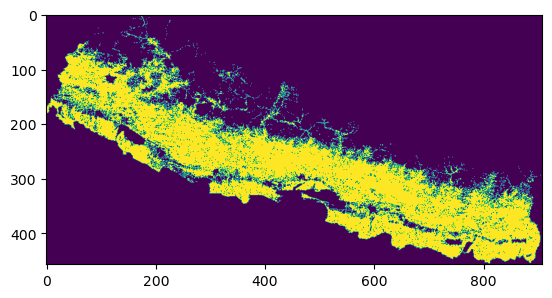

In [9]:
plt.imshow(arr)

In [10]:
esri_path = os.path.join(data_in + 'ESRI_WPE_2016_Pop/WPE_1KM_2016_Pop.tif')

In [11]:
esri = rio.open_rasterio(esri_path)
print(esri.rio.crs)
esri

EPSG:4326


<xarray.DataArray (band: 1, y: 14285, x: 40074)> Size: 2GB
[572457090 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 321kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 114kB 73.32 73.31 73.3 ... -54.98 -54.99 -55.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:           Area
    STATISTICS_MAXIMUM:      336720
    STATISTICS_MEAN:         401.47917136019
    STATISTICS_MINIMUM:      1
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       1594.7670745165
    _FillValue:              -2147483647
    scale_factor:            1.0
    add_offset:              0.0

In [12]:
gpw = rio.open_rasterio(gpw_path)
print(gpw.rio.crs)
gpw

NameError: name 'gpw_path' is not defined

In [ ]:
print(esri.rio.nodata)
print('ESRI nan value is', esri.data[0][0][0])
print(gpw.rio.nodata)
print('ESRI nan value is', gpw.data[0][0][0])

In [ ]:
esri.data = np.where(esri.data < 1,-999, esri.data)
esri.data

In [ ]:
gpw.data = np.where(gpw.data < 1,-999, gpw.data)
gpw.data

In [ ]:
esri.rio.write_nodata(-999, inplace=True)

In [ ]:
gpw.rio.write_nodata(-999, inplace=True)

In [ ]:
print(esri.rio.nodata)
print(gpw.rio.nodata)

In [ ]:
print(esri.attrs['_FillValue'])
print(gpw.attrs['_FillValue'])

In [ ]:
esri_match = esri.rio.reproject_match(gpw)

In [ ]:
gpw_match = gpw.rio.reproject_match(gpw)

In [ ]:
esri_match.rio.to_raster(data_out + 'esri2016_npl_matched.tif')

In [ ]:
rst_fn = data_out + 'esri2016_npl_matched.tif'

In [ ]:
# split for naming
rst_nm = rst_fn.split('a/')[1].split('.tif')[0]
print(rst_nm)


In [ ]:
# open pop rasters and get array
arr = rasterio.open(rst_fn).read(1)
mask = np.where(arr == -999, 0, 1)

In [ ]:
# Open modis urban/rural land cover
modis_match_fn = data_out+'MGUP15_2015-1km-npl-matched.tif'
modis_arr = rasterio.open(modis_match_fn).read(1)
modis_arr

In [ ]:
# multiply for urban
lc_urban = modis_arr == 1
arr_urban = arr * lc_urban * mask
arr_urban 


In [ ]:
plt.imshow(arr_urban)

In [ ]:
# multiply for rural
lc_rural = modis_arr != 1
arr_rural = arr * lc_rural * mask
arr_rural

In [ ]:
plt.imshow(arr_rural, vmin = 100)

In [ ]:
# meta data
meta = rasterio.open(rst_fn).meta

# write out urban
meta['dtype'] = arr_urban.dtype
out_fn = data_out+rst_nm+'_urban.tif'
print(out_fn)
with rasterio.open(out_fn, 'w', **meta) as out:
    out.write_band(1, arr_urban)

# write out rural 
meta['dtype'] = arr_rural.dtype
out_fn = data_out+rst_nm+'_rural.tif'
print(out_fn)
with rasterio.open(out_fn, 'w', **meta) as out:
    out.write_band(1, arr_rural)
print('done \n')

In [ ]:
def poly_prep(polys_fn, col):
    """
    Prepares polygon data for use in zonal statistics calculations by opening the file and subsetting the necessary columns.

    Args:
        polys_fn (str): The file path to the polygon shapefile or GeoJSON file containing the polygons.
        col (str): The column name in the polygon file that will be retained along with the geometry for later use in the zonal statistics calculations.

    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame containing only the geometry and the specified column from the input file.

    Process:
        1. Opens the polygon file using `geopandas.read_file()`.
        2. Subsets the data to keep only the 'geometry' column and the specified column (`col`).
        3. Returns the prepared GeoDataFrame for further use in zonal statistics or other spatial analyses.

    Example:
        polygons = poly_prep('earthquake_polygons.shp', 'admin_level')

    Notes:
        - Ensure that the input file is in a format readable by `geopandas`, such as a shapefile (.shp) or GeoJSON (.geojson).
        - The column specified by `col` should be present in the input file, as it will be retained for later analysis.
    """    
    # open
    polys = gpd.read_file(polys_fn)
    
    # subset, be sure to check the admin level
    polys = polys[['geometry', col]]
    
    return polys

In [ ]:
# Open the shape map polygons
nepal_polys_fn = os.path.join(data_in + 'USGS_Data/Nepal/shape/mi.shp')

In [ ]:
# Subset the polygons
col = 'PARAMVALUE'
nepal_polys = poly_prep(nepal_polys_fn, col)
nepal_polys.head()

In [ ]:
rst = './data/esri2016_npl.tif'

In [ ]:
split = '_npl.tif'
stats_type = 'sum'

In [ ]:
polys_out = nepal_polys.copy()

# Get data name
print(rst)
data = rst.split('data/')[1].split(split)[0].split('.tif')[0]
print('Started', data)

# Run zonal stats
zs_feats = zonal_stats(nepal_polys, rst, stats=stats_type, geojson_out=True, nodata = -999.)
zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=nepal_polys.crs)

# Rename columns and merge
zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
npl_all = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')

In [ ]:
rst = './data/esri2016_npl_matched_urban.tif'

In [ ]:
polys_out = nepal_polys.copy()

# Get data name
print(rst)
data = rst.split('data/')[1].split(split)[0].split('.tif')[0]
print('Started', data)

# Run zonal stats
zs_feats = zonal_stats(nepal_polys, rst, stats=stats_type, geojson_out=True, nodata = -999)
zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=nepal_polys.crs)

# Rename columns and merge
zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
urban_all = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')

In [ ]:
rst = './data/esri2016_npl_matched_rural.tif'

In [ ]:
polys_out = nepal_polys.copy()

# Get data name
print(rst)
data = rst.split('data/')[1].split(split)[0].split('.tif')[0]
print('Started', data)

# Run zonal stats
zs_feats = zonal_stats(nepal_polys, rst, stats=stats_type, geojson_out=True, nodata = -999)
zgdf = gpd.GeoDataFrame.from_features(zs_feats, crs=nepal_polys.crs)

# Rename columns and merge
zgdf = zgdf.rename(columns={stats_type: data+'_'+stats_type})
rural_all = polys_out.merge(zgdf[[col, data+'_'+stats_type]], on = col, how = 'inner')

In [ ]:
round((urban_all.iloc[:,2] + rural_all.iloc[:,2]) / npl_all.iloc[:,2], 2)